In [1]:
PYTHON_PATHS = [".."]
import sys
import cv2
import os
import pandas as pd
import numpy as np
import kornia
import torch
import rosbag
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path
from tqdm.notebook import tqdm

for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
try:
    from enlighten_inference import EnlightenOnnxModel
except ImportError:
    !pip install git+https://github.com/arsenyinfo/EnlightenGAN-inference
    from enlighten_inference import EnlightenOnnxModel

from kapture_localization.matching.matching import MatchPairNnTorch
from torch.nn.functional import grid_sample
from ros_bag_processing.enlighting.hist_norm import HistNormModel
from ros_bag_processing.enlighting.gamma import GammaModel
from ros_bag_processing.enlighting.enlighten_gan import EnlightenGanModel

/opt/ros/melodic/lib/python2.7/dist-packages/rosbag/bag.py:1567: DeprecationWarning: invalid escape sequence \d
  matches = re.match("#ROS(.*) V(\d).(\d)", version_line)
/opt/ros/melodic/lib/python2.7/dist-packages/rospy/core.py:183: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logfunc(msg, *args, **kwargs)
Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/home/andrei/miniconda3/envs/enGAN/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
!pip uninstall -y onnxruntime
!pip install onnxruntime-gpu
import onnxruntime as rt
rt.get_device()

'GPU'

### Load data

In [4]:
def read_bag(file_path, type='r'):
    return rosbag.Bag(file_path, type)

def check_dir(directory):
    print("Output will be saved in directory: {}".format(directory))
    if not os.path.exists(directory):
        print('New directory created')
        os.mkdir(directory)
            
def bag2images(bag_path, out_dir='output', img_topic='/camera/image_cropped'):
    bag = read_bag(bag_path)

    check_dir(out_dir)

    cnt = 0
    for topic, msg, t in tqdm(bag.read_messages(topics=[img_topic])):
        img = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, -1)
        out_im_path = os.path.join(out_dir, '%06i.png' % cnt)
        cv2.imwrite(out_im_path, img)
        cnt += 1
#         print('Wrote image: %i' % cnt)
    bag.close()


### Dataset path

In [5]:
def get_path(bag_number):
    dataset_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "datasets")
    list_of_bags = [_ for _ in os.listdir(dataset_path) if _.endswith(r".bag")]
    bag_path = os.path.join(dataset_path, list_of_bags[bag_number])
    check_dir(os.path.join(dataset_path, list_of_bags[bag_number][:-4]))
    output_img_path = os.path.join(dataset_path, list_of_bags[bag_number][:-4])
    return bag_path, output_img_path

### Convert bag to images

In [6]:
bag_path, output_img_path = get_path(0)

Output will be saved in directory: /home/andrei/git/VSLAM_articles/ros-bag-processing/datasets/2021-11-24-21-10-35
New directory created


In [7]:
bag2images(bag_path, output_img_path)

Output will be saved in directory: /home/andrei/git/VSLAM_articles/ros-bag-processing/datasets/2021-11-24-21-10-35


0it [00:00, ?it/s]

### Processing

In [8]:
def orb_feature_exctraction(img):
    orb = cv2.ORB_create()
    kp, descr = orb.detectAndCompute(img, None)
    orb_img = cv2.drawKeypoints(img, kp, None)
    return orb_img, kp, descr

def sift_feature_exctraction(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descr = sift.detectAndCompute(img, None)
    sift_img = cv2.drawKeypoints(img, kp, None)
    return sift_img, kp, descr

In [9]:
def extract_key_points_coordinates(keypoints_1, keypoints_2):
    keypoints_1_x_y = []
    keypoints_2_x_y = []
    for points in keypoints_1:
        keypoints_1_x_y.append(list(points.pt))
    for points in keypoints_2:
        keypoints_2_x_y.append(list(points.pt))
    return np.asarray(keypoints_1_x_y), np.asarray(keypoints_2_x_y)

def feature_matching(descriptors_1, descriptors_2, norm):
    bf = cv2.BFMatcher(norm, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    return matches

def extract_data(matches):
    matches_dist = []
    matches_queryIdx = []
    matches_trainIdx = []
    for points in matches:
        matches_dist.append(int(points.distance))
        matches_queryIdx.append(int(points.queryIdx))
        matches_trainIdx.append(int(points.trainIdx))
    return matches_dist, matches_queryIdx, matches_trainIdx
        
def matched_keypoints(keypoints_1_x_y, keypoints_2_x_y,
                      matches_queryIdx, matches_trainIdx, matches_dist):
    matched_keypoints1 = []
    matched_keypoints2 = []
    i = 0 
    for match in matches_dist:
        matched_keypoints1.append(keypoints_1_x_y[int(matches_queryIdx[i])])
        matched_keypoints2.append(keypoints_2_x_y[int(matches_trainIdx[i])])
        i = i + 1

    return np.array(matched_keypoints1), np.array(matched_keypoints2)

In [10]:
def plot_matching(img_1, img_2, keypoints_1_x_y, keypoints_2_x_y, matches, mask):
    pass
    plt.figure(dpi=200)
    output_image = np.concatenate([img_1, img_2], axis=1)
    plt.imshow(output_image)
    plt.scatter(keypoints_1_x_y[:, 0], keypoints_1_x_y[:, 1], s=1)
    plt.scatter(keypoints_2_x_y[:, 0] + 640, keypoints_2_x_y[:, 1], s=1)
    i=0
    for points in matches:
        color = "green" if mask[i, 0] else "red" 
        i = i + 1
        plt.plot([keypoints_1_x_y[int(points.queryIdx), 0], keypoints_2_x_y[int(points.trainIdx), 0] + 640], 
                 [keypoints_1_x_y[int(points.queryIdx), 1], keypoints_2_x_y[int(points.trainIdx), 1]], linewidth=1, c=color)   
    plt.axis('off');

In [11]:
def prediction_models(gamma=1):
    GAN = EnlightenGanModel()
    HIST = HistNormModel()
    GAMMA = GammaModel(gamma)
    return GAN, HIST, GAMMA

def process_image(img, model=None):
    if model != None:
        img = model.predict(img)
    return img

def find_matches(img1, img2, good_features, bad_matching_index, index):
    try:
        # data extraction
        img_1, keypoints_1, descriptors_1 = orb_feature_exctraction(img1)
        img_2, keypoints_2, descriptors_2 = orb_feature_exctraction(img2)

        # data converstion 
        keypoints_1_x_y, keypoints_2_x_y = extract_key_points_coordinates(keypoints_1, keypoints_2)
        matches = feature_matching(descriptors_1, descriptors_2, cv2.NORM_HAMMING)
        matches_dist, matches_queryIdx, matches_trainIdx = extract_data(matches)

        # data matching
        matched_keypoints1, matched_keypoints2 = matched_keypoints(keypoints_1_x_y, keypoints_2_x_y,
                                                                   matches_queryIdx, matches_trainIdx,
                                                                   matches_dist)
        try:
            fundamental_matrix, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2, cv2.UsacParams())
            good_features.append(np.count_nonzero(mask==1))
        except:
            good_features.append(0)
            bad_matching_index.append(index)
    except:
        good_features.append(0)
        bad_matching_index.append(index)        
    
def match_dataset_images(output_img_path, model=None):
    dataset_images = os.listdir(output_img_path)
    dataset_images = sorted(dataset_images)
    index = 0
    good_features = []
    bad_matching_index = []
    bad_matching = 0
    
    path1 = os.path.join(output_img_path, dataset_images[0])
    path2 = os.path.join(output_img_path, dataset_images[1])

    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    # Process image
    img1 = process_image(img1, model)
    img2 = process_image(img2, model)
    find_matches(img1, img2, good_features, bad_matching_index, index)

    for index in tqdm(range(len(dataset_images)-2)):
        img1 = img2.copy()
        path2 = os.path.join(output_img_path, dataset_images[index+2])
        img2 = cv2.imread(path2)
        img2 = process_image(img2, model)
        
        find_matches(img1, img2, good_features, bad_matching_index, index)

        index += 1
    return good_features, bad_matching_index

In [12]:
GAN, HIST, GAMMA = prediction_models(2.4)
good_features, bad_matching_index = match_dataset_images(output_img_path, model=None)
good_features_GAN, bad_matching_index_GAN = match_dataset_images(output_img_path, model=GAN)
good_features_HIST, bad_matching_index_HIST = match_dataset_images(output_img_path, model=HIST)
good_features_GAMMA, bad_matching_index_GAMMA = match_dataset_images(output_img_path, model=GAMMA)

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

### Graphs

In [13]:
def smoothing(numbers, window_size):
    numbers_series = pd.Series(numbers)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    without_nans = moving_averages_list[window_size - 1:]
    return without_nans

def plot_all_graphs(good_features):
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    i = 0
    names = ['Good features default', 'Good features HIST', 'Good features GAN', 'Good features GAMMA']
    for data_array in good_features:
        window_size=10
        x = np.linspace(0, len(data_array)-1-window_size+1, len(data_array)-window_size+1)
        y = smoothing(data_array, window_size=10)

        line = ax.plot(x, y, label=names[i])
        i = i + 1
    ax.set_xlabel('Steps')
    ax.set_ylabel('Number of features')
    ax.legend()
    plt.show()

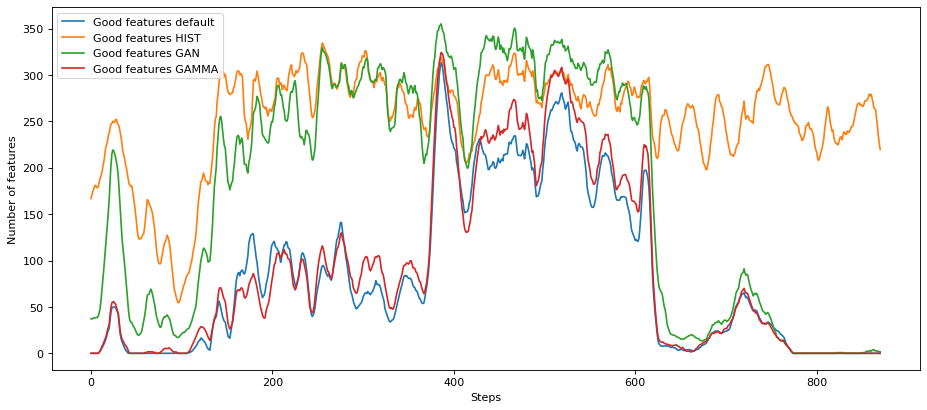

In [14]:
plot_all_graphs([good_features, good_features_HIST, good_features_GAN, good_features_GAMMA])

In [13]:
def smoothing(numbers, window_size):
    numbers_series = pd.Series(numbers)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    without_nans = moving_averages_list[window_size - 1:]
    return without_nans

def plot_all_graphs(good_features):
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    i = 0
    names = ['GAMMA 1','GAMMA 2.4','GAMMA 3','GAMMA 4','GAMMA 5','GAMMA 6']
    for data_array in good_features:
        window_size=10
        x = np.linspace(0, len(data_array)-1-window_size+1, len(data_array)-window_size+1)
        y = smoothing(data_array, window_size=10)

        line = ax.plot(x, y, label=names[i])
        i = i + 1
    ax.set_xlabel('Steps')
    ax.set_ylabel('Number of features')
    ax.legend()
    plt.show()
    
GAN, HIST, GAMMA = prediction_models(1)
good_features_GAMMA1, bad_matching_index_GAMMA1 = match_dataset_images(output_img_path, model=GAMMA)
GAN, HIST, GAMMA = prediction_models(2.4)
good_features_GAMMA2, bad_matching_index_GAMMA2 = match_dataset_images(output_img_path, model=GAMMA)
GAN, HIST, GAMMA = prediction_models(3)
good_features_GAMMA3, bad_matching_index_GAMMA3 = match_dataset_images(output_img_path, model=GAMMA)
GAN, HIST, GAMMA = prediction_models(4)
good_features_GAMMA4, bad_matching_index_GAMMA4 = match_dataset_images(output_img_path, model=GAMMA)
GAN, HIST, GAMMA = prediction_models(5)
good_features_GAMMA5, bad_matching_index_GAMMA5 = match_dataset_images(output_img_path, model=GAMMA)
GAN, HIST, GAMMA = prediction_models(6)
good_features_GAMMA6, bad_matching_index_GAMMA6 = match_dataset_images(output_img_path, model=GAMMA)

plot_all_graphs([good_features_GAMMA1, good_features_GAMMA2, good_features_GAMMA3, good_features_GAMMA4, good_features_GAMMA5, good_features_GAMMA6])

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]